# Introduction

In this lab, we will use scikit-learn to demonstrate how to compute the positive and negative likelihood ratios (**LR+**, **LR-**) to assess the predictive power of a binary classifier. These metrics are independent of the proportion between classes in the test set, which makes them very useful when the available data for a study has a different class proportion than the target application. We will go through the following steps:

# Preparing the Data

We will generate a synthetic dataset using the **make_classification** function from scikit-learn. This dataset will simulate a population with a minority of subjects carrying a disease.

In [10]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10_000, weights=[0.9, 0.1], random_state=0)
print(f"Percentage of people carrying the disease: {100 * y.mean():.2f}%")

Percentage of people carrying the disease: 10.37%


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Pre-test vs. Post-test Analysis

We will fit a logistic regression model to the data and evaluate its performance on a held-out test set. We will compute the positive likelihood ratio to evaluate the usefulness of this classifier as a disease diagnosis tool.

# Cross-validation of Likelihood Ratios

We will assess the variability of the measurements for the class likelihood ratios in some particular cases using cross-validation.

# Invariance with Respect to Prevalence

We will show that the class likelihood ratios are independent of the disease prevalence and can be extrapolated between populations regardless of any possible class imbalance.

# Preparing the Data

We will generate a synthetic dataset using the **make_classification** function from scikit-learn. This dataset will simulate a population with a minority of subjects carrying a disease.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import class_likelihood_ratios

estimator = LogisticRegression().fit(X_train, y_train)
y_pred = estimator.predict(X_test)
pos_LR, neg_LR = class_likelihood_ratios(y_test, y_pred)
print(f"LR+: {pos_LR:.3f}")

LR+: 12.617


# Cross-validation of Likelihood Ratios

We will assess the variability of the measurements for the class likelihood ratios in some particular cases using cross-validation.

In [16]:
import pandas as pd


def scoring(estimator, X, y):
    y_pred = estimator.predict(X)
    pos_lr, neg_lr = class_likelihood_ratios(y, y_pred)
    return {"positive_likelihood_ratio": pos_lr, "negative_likelihood_ratio": neg_lr}


def extract_score(cv_results):
    lr = pd.DataFrame(
        {
            "positive": cv_results["test_positive_likelihood_ratio"],
            "negative": cv_results["test_negative_likelihood_ratio"],
        }
    )
    return lr.aggregate(["mean", "std"])

We first validate the LogisticRegression model with default hyperparameters as used in the previous section.

In [17]:
from sklearn.model_selection import cross_validate

estimator = LogisticRegression()
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negative
mean,16.661086,0.724702
std,4.383973,0.054045


We confirm that the model is useful: the post-test odds are between 12 and 20 times larger than the pre-test odds.

On the contrary, let’s consider a dummy model that will output random predictions with similar odds as the average disease prevalence in the training set:

In [18]:
from sklearn.dummy import DummyClassifier

estimator = DummyClassifier(strategy="stratified", random_state=1234)
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negative
mean,1.108843,0.986989
std,0.268147,0.034278


Here both class likelihood ratios are compatible with 1.0 which makes this classifier useless as a diagnostic tool to improve disease detection.

Another option for the dummy model is to always predict the most frequent class, which in this case is “no-disease”.

In [19]:
estimator = DummyClassifier(strategy="most_frequent")
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: no samples predicted for the positive class
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: no samples predicted for the positive class
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: no samples predicted for the positive class
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: no samples predicted for the positive class
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: no samples predicted for the positi

,positive,negative
mean,NaN,1.0
std,NaN,0.0


The absence of positive predictions means there will be no true positives nor false positives, leading to an undefined LR+ that by no means should be interpreted as an infinite LR+ (the classifier perfectly identifying positive cases). In such situation the class_likelihood_ratios function returns nan and raises a warning by default. Indeed, the value of LR- helps us discard this model.

A similar scenario may arise when cross-validating highly imbalanced data with few samples: some folds will have no samples with the disease and therefore they will output no true positives nor false negatives when used for testing. Mathematically this leads to an infinite LR+, which should also not be interpreted as the model perfectly identifying positive cases. Such event leads to a higher variance of the estimated likelihood ratios, but can still be interpreted as an increment of the post-test odds of having the condition.

In [20]:
estimator = LogisticRegression()
X, y = make_classification(n_samples=300, weights=[0.9, 0.1], random_state=0)
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: positive_likelihood_ratio ill-defined and being set to nan 
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: positive_likelihood_ratio ill-defined and being set to nan 
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: positive_likelihood_ratio ill-defined and being set to nan 
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:216: UserWarning: positive_likelihood_ratio ill-defined and being set to nan 
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_val

,positive,negative
mean,17.8000,0.373333
std,8.5557,0.235430


# Invariance with respect to prevalence

The likelihood ratios are independent of the disease prevalence and can be extrapolated between populations regardless of any possible class imbalance, **as long as the same model is applied to all of them**. Notice that in the plots below **the decision boundary is constant** (see SVM: Separating hyperplane for unbalanced classes for a study of the boundary decision for unbalanced classes).

Here we train a LogisticRegression base model on a case-control study with a prevalence of 50%. It is then evaluated over populations with varying prevalence. We use the make_classification function to ensure the data-generating process is always the same as shown in the plots below. The label 1 corresponds to the positive class “disease”, whereas the label 0 stands for “no-disease”.

In [21]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

from sklearn.inspection import DecisionBoundaryDisplay

populations = defaultdict(list)
common_params = {
    'n_samples': 10_000,
    'n_features': 2,
    'n_informative': 2,
    'n_redundant': 0,
    'random_state': 0,
}
weights = np.linspace(0.1, 0.8, 6)
weights = weights[::-1]

# fift and evaluate base model on balanced classes
X, y = make_classification(**common_params, weights=[0.5, 0.5])
estimator = LogisticRegression().fit(X, y)
lr_base = extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))
pos_lr_base, pos_lr_base_std = lr_base['positive'].values
neg_lr_base, neg_lr_base_std = lr_base['negative'].values

We will now show the decision boundary for each level of prevalence. Note that we only plot a subset of the original data to better assess the linear model decision boundary.

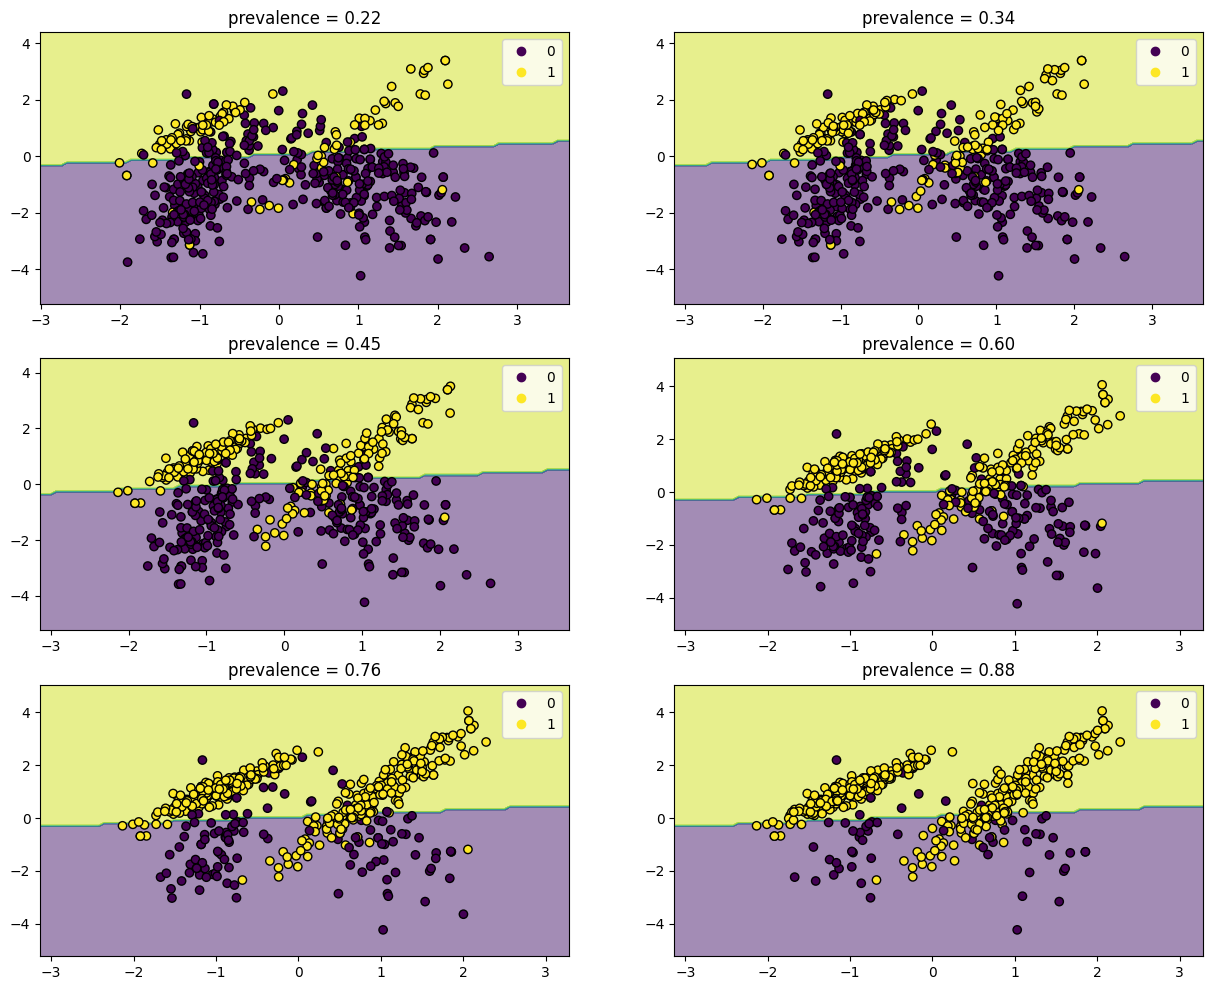

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

for ax, (n, weight) in zip(axs.ravel(), enumerate(weights)):
    X, y = make_classification(
        **common_params,
        weights=[weight, 1 - weight],
    )
    prevalence = y.mean()
    populations["prevalence"].append(prevalence)
    populations["X"].append(X)
    populations["y"].append(y)

    # down-sample for plotting
    rng = np.random.RandomState(1)
    plot_indices = rng.choice(np.arange(X.shape[0]), size=500, replace=True)
    X_plot, y_plot = X[plot_indices], y[plot_indices]

    # plot fixed decision boundary of base model with varying prevalence
    disp = DecisionBoundaryDisplay.from_estimator(
        estimator,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolor="k")
    disp.ax_.set_title(f"prevalence = {y_plot.mean():.2f}")
    disp.ax_.legend(*scatter.legend_elements())

We define a function for bootstrapping.

In [23]:
def scoring_on_bootstrap(estimator, X, y, rng, n_bootstrap=100):
    results_for_prevalence = defaultdict(list)
    for _ in range(n_bootstrap):
        bootstrap_indices = rng.choice(
            np.arange(X.shape[0]), size=X.shape[0], replace=True
        )
        for key, value in scoring(
            estimator, X[bootstrap_indices], y[bootstrap_indices]
        ).items():
            results_for_prevalence[key].append(value)
    return pd.DataFrame(results_for_prevalence)

We score the base model for each prevalence using bootstrapping.



In [24]:
results = defaultdict(list)
n_bootstrap = 100
rng = np.random.default_rng(seed=0)

for prevalence, X, y in zip(
    populations["prevalence"], populations["X"], populations["y"]
):
    results_for_prevalence = scoring_on_bootstrap(
        estimator, X, y, rng, n_bootstrap=n_bootstrap
    )
    results["prevalence"].append(prevalence)
    results["metrics"].append(
        results_for_prevalence.aggregate(["mean", "std"]).unstack()
    )

results = pd.DataFrame(results["metrics"], index=results["prevalence"])
results.index.name = "prevalence"
results

positive_likelihood_ratio           negative_likelihood_ratio  \
                                mean       std                      mean   
prevalence                                                                 
0.2039                      4.507943  0.113516                  0.207667   
0.3419                      4.443238  0.125140                  0.198766   
0.4809                      4.421087  0.123828                  0.192913   
0.6196                      4.409717  0.164009                  0.193949   
0.7578                      4.334795  0.175298                  0.189267   
0.8963                      4.197666  0.238955                  0.185654   

                      
                 std  
prevalence            
0.2039      0.009778  
0.3419      0.008915  
0.4809      0.006360  
0.6196      0.005861  
0.7578      0.005840  
0.8963      0.005027

In the plots below we observe that the class likelihood ratios re-computed with different prevalences are indeed constant within one standard deviation of those computed with on balanced classes.



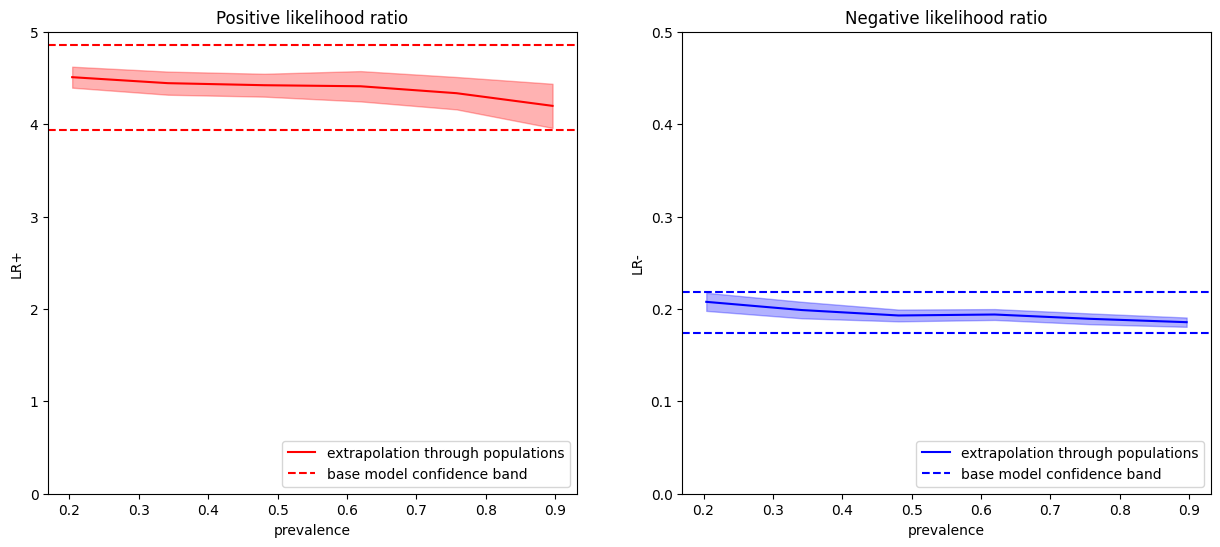

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
results["positive_likelihood_ratio"]["mean"].plot(
    ax=ax1, color="r", label="extrapolation through populations"
)
ax1.axhline(y=pos_lr_base + pos_lr_base_std, color="r", linestyle="--")
ax1.axhline(
    y=pos_lr_base - pos_lr_base_std,
    color="r",
    linestyle="--",
    label="base model confidence band",
)
ax1.fill_between(
    results.index,
    results["positive_likelihood_ratio"]["mean"]
    - results["positive_likelihood_ratio"]["std"],
    results["positive_likelihood_ratio"]["mean"]
    + results["positive_likelihood_ratio"]["std"],
    color="r",
    alpha=0.3,
)
ax1.set(
    title="Positive likelihood ratio",
    ylabel="LR+",
    ylim=[0, 5],
)
ax1.legend(loc="lower right")

ax2 = results["negative_likelihood_ratio"]["mean"].plot(
    ax=ax2, color="b", label="extrapolation through populations"
)
ax2.axhline(y=neg_lr_base + neg_lr_base_std, color="b", linestyle="--")
ax2.axhline(
    y=neg_lr_base - neg_lr_base_std,
    color="b",
    linestyle="--",
    label="base model confidence band",
)
ax2.fill_between(
    results.index,
    results["negative_likelihood_ratio"]["mean"]
    - results["negative_likelihood_ratio"]["std"],
    results["negative_likelihood_ratio"]["mean"]
    + results["negative_likelihood_ratio"]["std"],
    color="b",
    alpha=0.3,
)
ax2.set(
    title="Negative likelihood ratio",
    ylabel="LR-",
    ylim=[0, 0.5],
)
ax2.legend(loc="lower right")

plt.show()

# Summary

In this lab, we have learned how to compute the positive and negative likelihood ratios to assess the predictive power of a binary classifier. These metrics are independent of the proportion between classes in the test set, making them very useful when the available data for a study has a different class proportion than the target application. We also learned how to assess the variability of the measurements for the class likelihood ratios in some particular cases using cross-validation and how to show that the class likelihood ratios are independent of the disease prevalence.